In [1]:
import os
os.getpid()

30235

In [713]:
from pathlib import Path
from io import BytesIO

import numpy as np
import pandas as pd
import cv2 as cv

import PIL
from PIL import Image, ImageDraw

from google.cloud import vision

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str('gcp_credentials.json')

In [4]:
root_path = Path('data/misaligned_images/misaligned_images/')

In [595]:
list(root_path.rglob('*.jpg'))

[PosixPath('data/misaligned_images/misaligned_images/law-firm-invoice-template.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/0f97914844b786b0d2ef21339286cdf6 - 2.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/10.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/6 2.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/5f228310d55c683ed29aa8c0adda7efc.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/AWT009.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/4.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/billing-invoice-for-legal-services.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/5.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/7.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/6.jpg'),
 PosixPath('data/misaligned_images/misaligned_images/0e27f636242845138158f132878a3351.jpg')]

In [671]:
sample_img = root_path / '4.jpg'
sample_img = root_path / 'law-firm-invoice-template.jpg'
sample_img = root_path / '7.jpg'
assert sample_img.exists()

In [672]:
client = vision.ImageAnnotatorClient()

In [673]:
def make_apicall(img):
#     client = vision.ImageAnnotatorClient()
    with BytesIO() as f:
        img_bytes = img.save(f, format='jpeg')
        image = vision.Image(content=f.getvalue())
        resp = client.document_text_detection(image=image)
    return resp

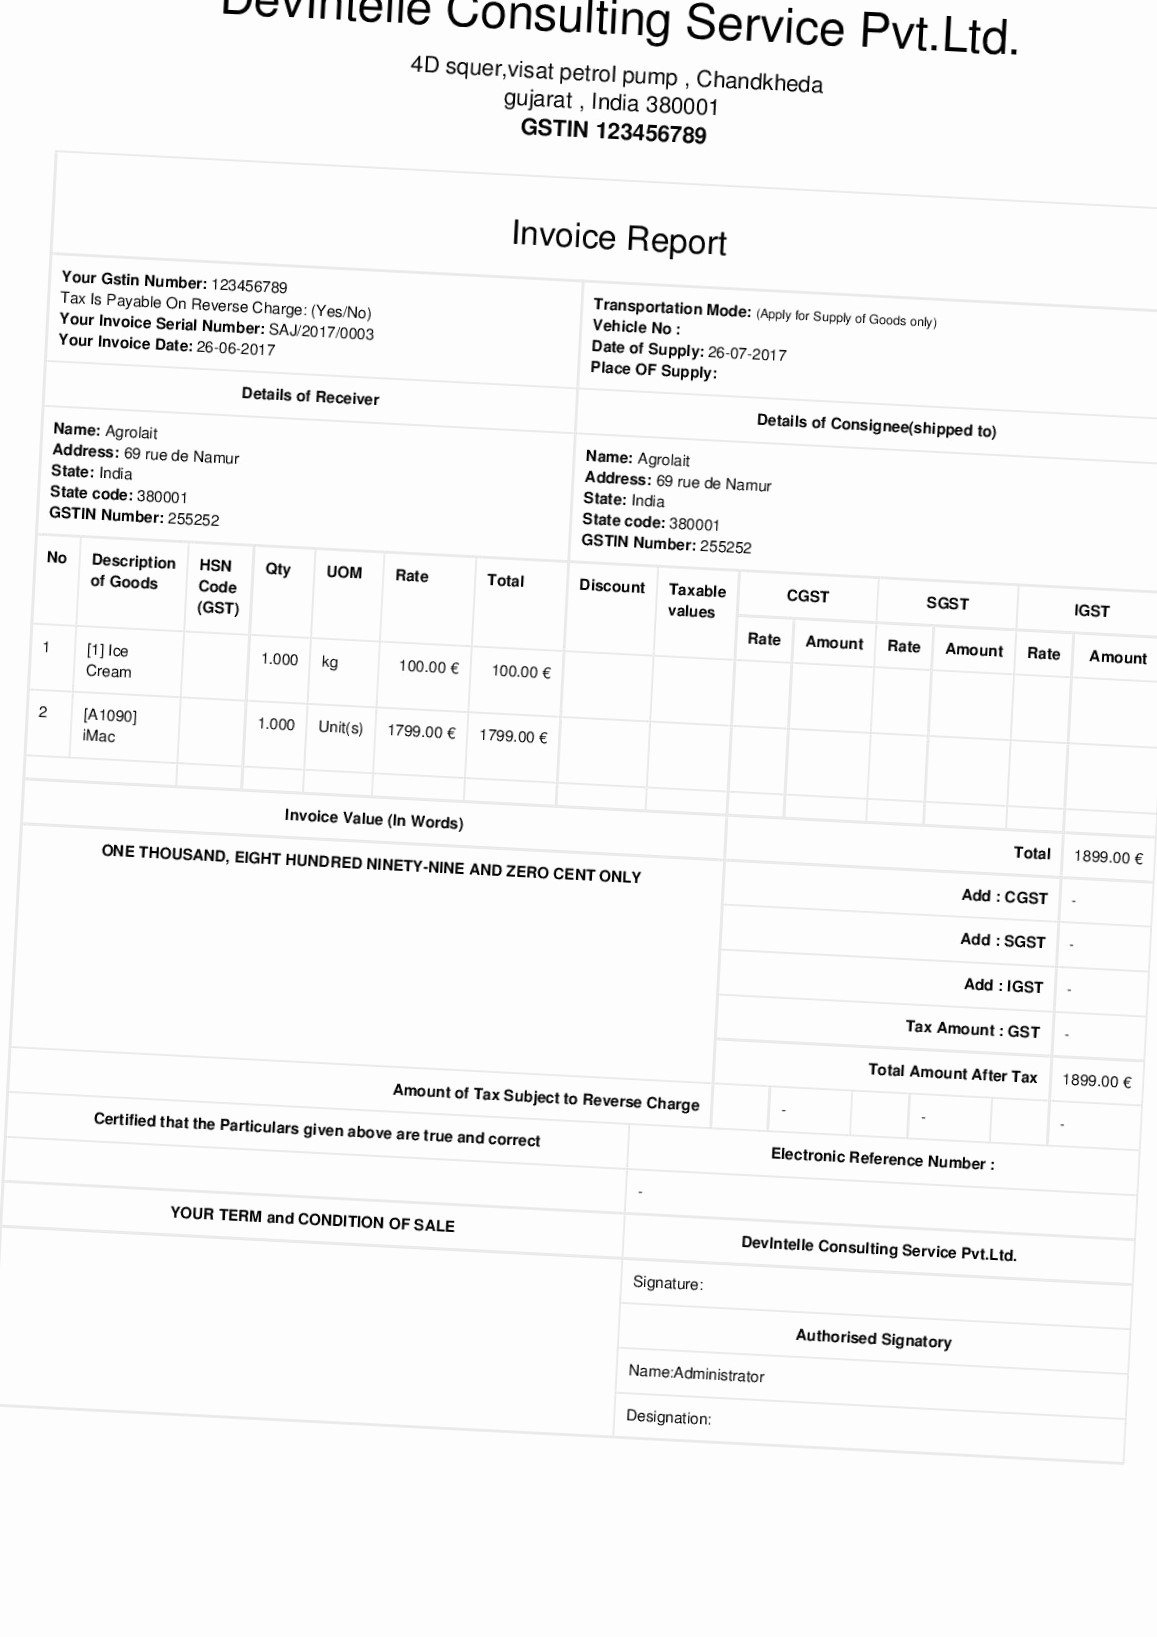

In [857]:
img = Image.open(sample_img)
img

In [675]:
%%time
resp = make_apicall(img)

CPU times: user 61.3 ms, sys: 0 ns, total: 61.3 ms
Wall time: 1.41 s


In [676]:
type(resp)

google.cloud.vision_v1.types.image_annotator.AnnotateImageResponse

In [677]:
from copy import deepcopy
orig_resp = deepcopy(resp)

In [678]:
resp == orig_resp

True

In [679]:
def draw_rect(orig_img, resp, annot_num=None):
    img = orig_img.copy()
    if annot_num is None:
        annot_nums = range(len(resp.text_annotations))
    else:
        annot_nums = [annot_num]
        
    print(len(annot_nums))
    d = ImageDraw.Draw(img)

    for anum in annot_nums:
        vertices = resp.text_annotations[anum].bounding_poly.vertices
        vertices_num = [(v.x, v.y) for v in vertices]
        assert len(vertices_num) == 4, len(vertices_num)
        
        d.polygon(vertices_num, outline='red')
        
    assert resp == orig_resp
    
    return img

257


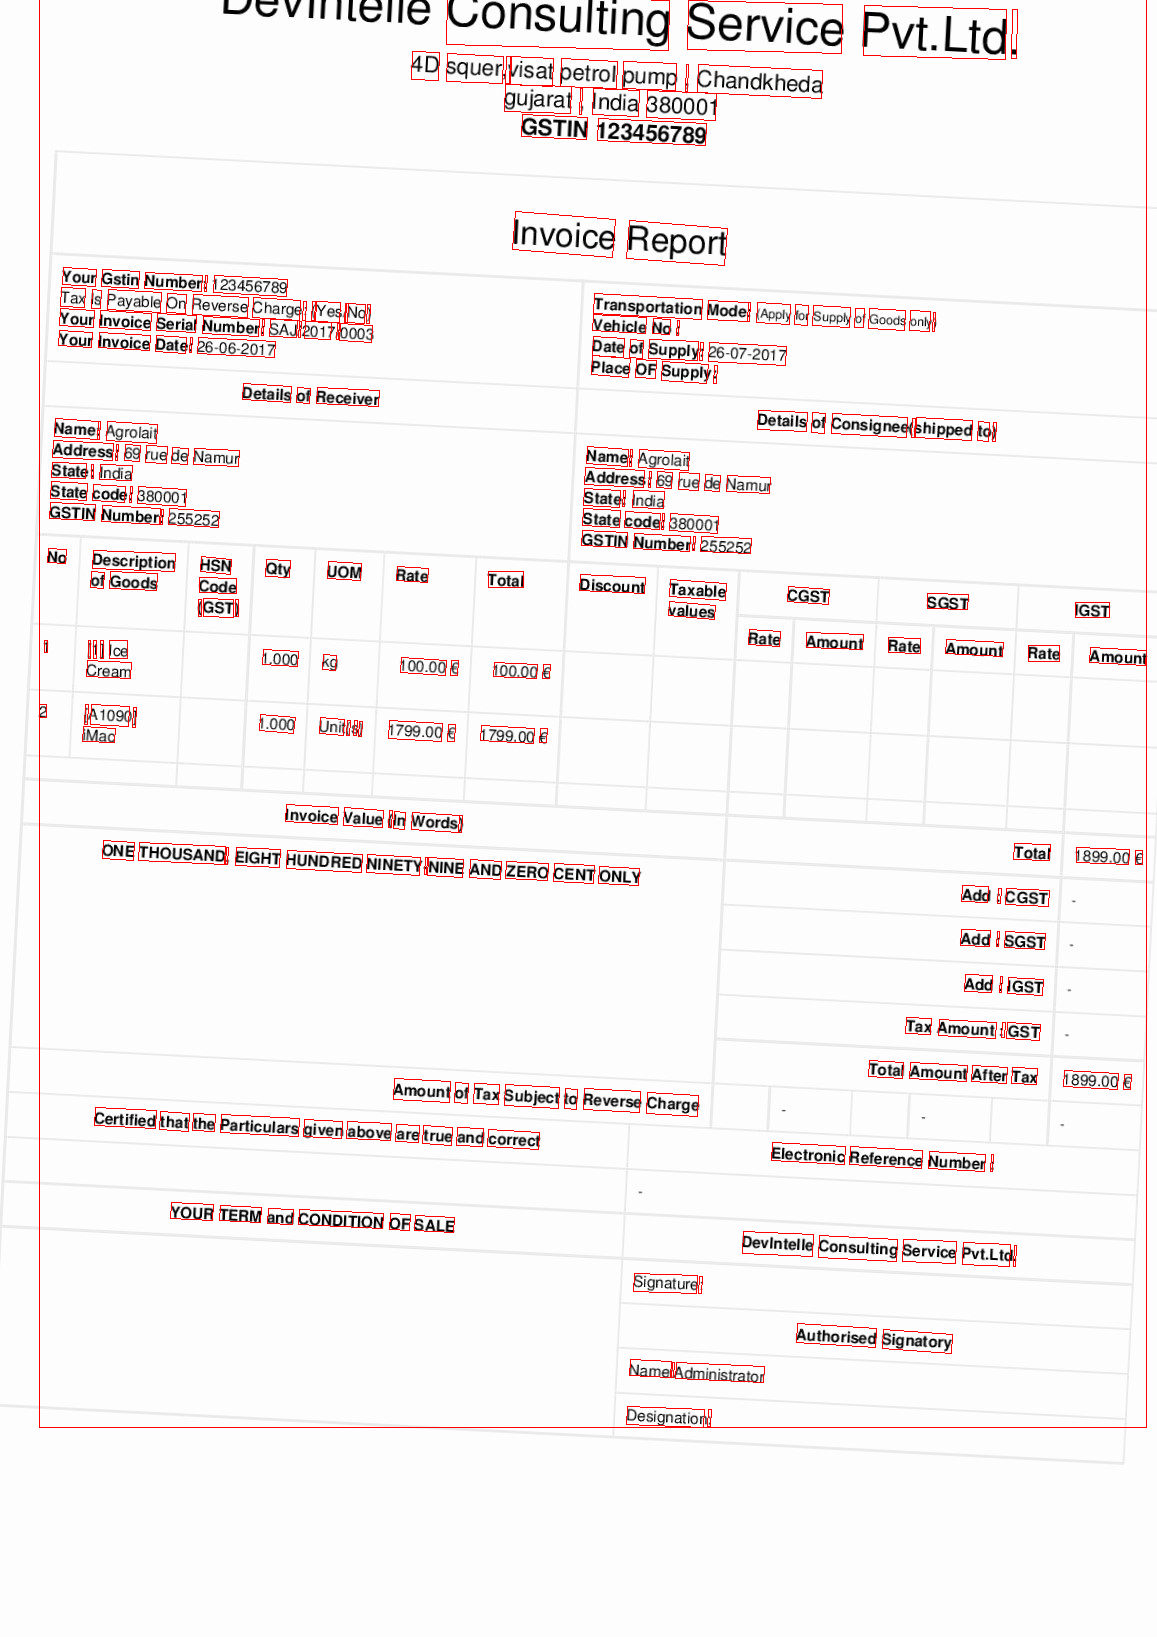

In [681]:
draw_rect(img, resp)

In [745]:
import statistics
from math import atan2, degrees
import math
import more_itertools as mit

def get_angle(orig_img, orig_resp, aggfn=statistics.median):
    img = orig_img.copy()
    resp = deepcopy(orig_resp)
    angles = []
    
    assert resp == orig_resp

    for annot  in resp.text_annotations:
#         print(i)
        vs = annot.bounding_poly.vertices
        assert len(vs) == 4, len(vs)
        
        line_points = [
            (vs[0], vs[1]),
            (vs[1], vs[2]),
            (vs[3], vs[2]),
            (vs[0], vs[3])
        ]
        
        angles.extend([
            get_angle_from_points(vs[0], vs[1]),
            get_angle_from_points(vs[3], vs[2])
        ])
        continue
        
        assert resp == orig_resp
        
        line_points = list(mit.pairwise(vs)) + [(vs[0], vs[3])]
        line_points = np.array(line_points)
        
        assert resp == orig_resp
        
        # get distances between adjacent points
        dists = np.array([get_distance_between_points(pair[0], pair[1]) for pair in line_points])
        assert len(dists) == 4, len(dists)
        
        assert resp == orig_resp
        
        # get 2 longest sides
        longest_sides = np.flip(np.argsort(dists))[:1]
        assert longest_sides.shape == (1, )
#         print(longest_sides, longest_sides.dtype)
        
        assert resp == orig_resp
    
        pair_angles = [get_angle_from_points(*pair) for pair in line_points]

        df = pd.DataFrame(data={'dists': dists, 'angles': pair_angles})
        print(df.to_markdown())
        print(df.iloc[longest_sides])

        assert resp == orig_resp
    
        angle = pair_angles[longest_sides[0]]
        print(angle, pair_angles, repr(annot.description))
#         print(angle, repr(annot.description))

        assert resp == orig_resp
    
#         angles.append(abs(angle))
#         angles = []
#         ang_l1 = get_angle_from_points(vs[0], vs[1])
#         ang_l2 = get_angle_from_points(vs[2], vs[3])
#         angles.extend([ang_l1, ang_l2])
    
        assert resp == orig_resp
    
    assert resp == orig_resp
        
#     print(angles)
#     angles = pd.Series(angles)
#     mean = statistics.mean(angles)
#     stdev = statistics.stdev(angles)
#     angles = angles.loc[angles.between((mean-stdev), (mean+stdev))]
    
    med_angle = aggfn(angles)
    return med_angle

def get_angle_from_points(v0, v1):
#     print(v0, v1)
#     y = int(v1.y) - int(v0.y)
#     x = int(v1.x) - int(v0.x)
    y = v1.y - v0.y
    x = v1.x - v0.x
    angle = degrees(atan2(y, x))
    return angle

def get_distance_between_points(v0, v1):
    return math.sqrt( (v1.x-v0.x)**2 + (v1.y-v0.y)**2 )


In [734]:
%%capture
get_angle(img, resp)

In [735]:
%%time
img_angle = get_angle(img, resp)

CPU times: user 39.1 ms, sys: 955 µs, total: 40.1 ms
Wall time: 36.9 ms


In [736]:
img_angle

2.7263109939062655

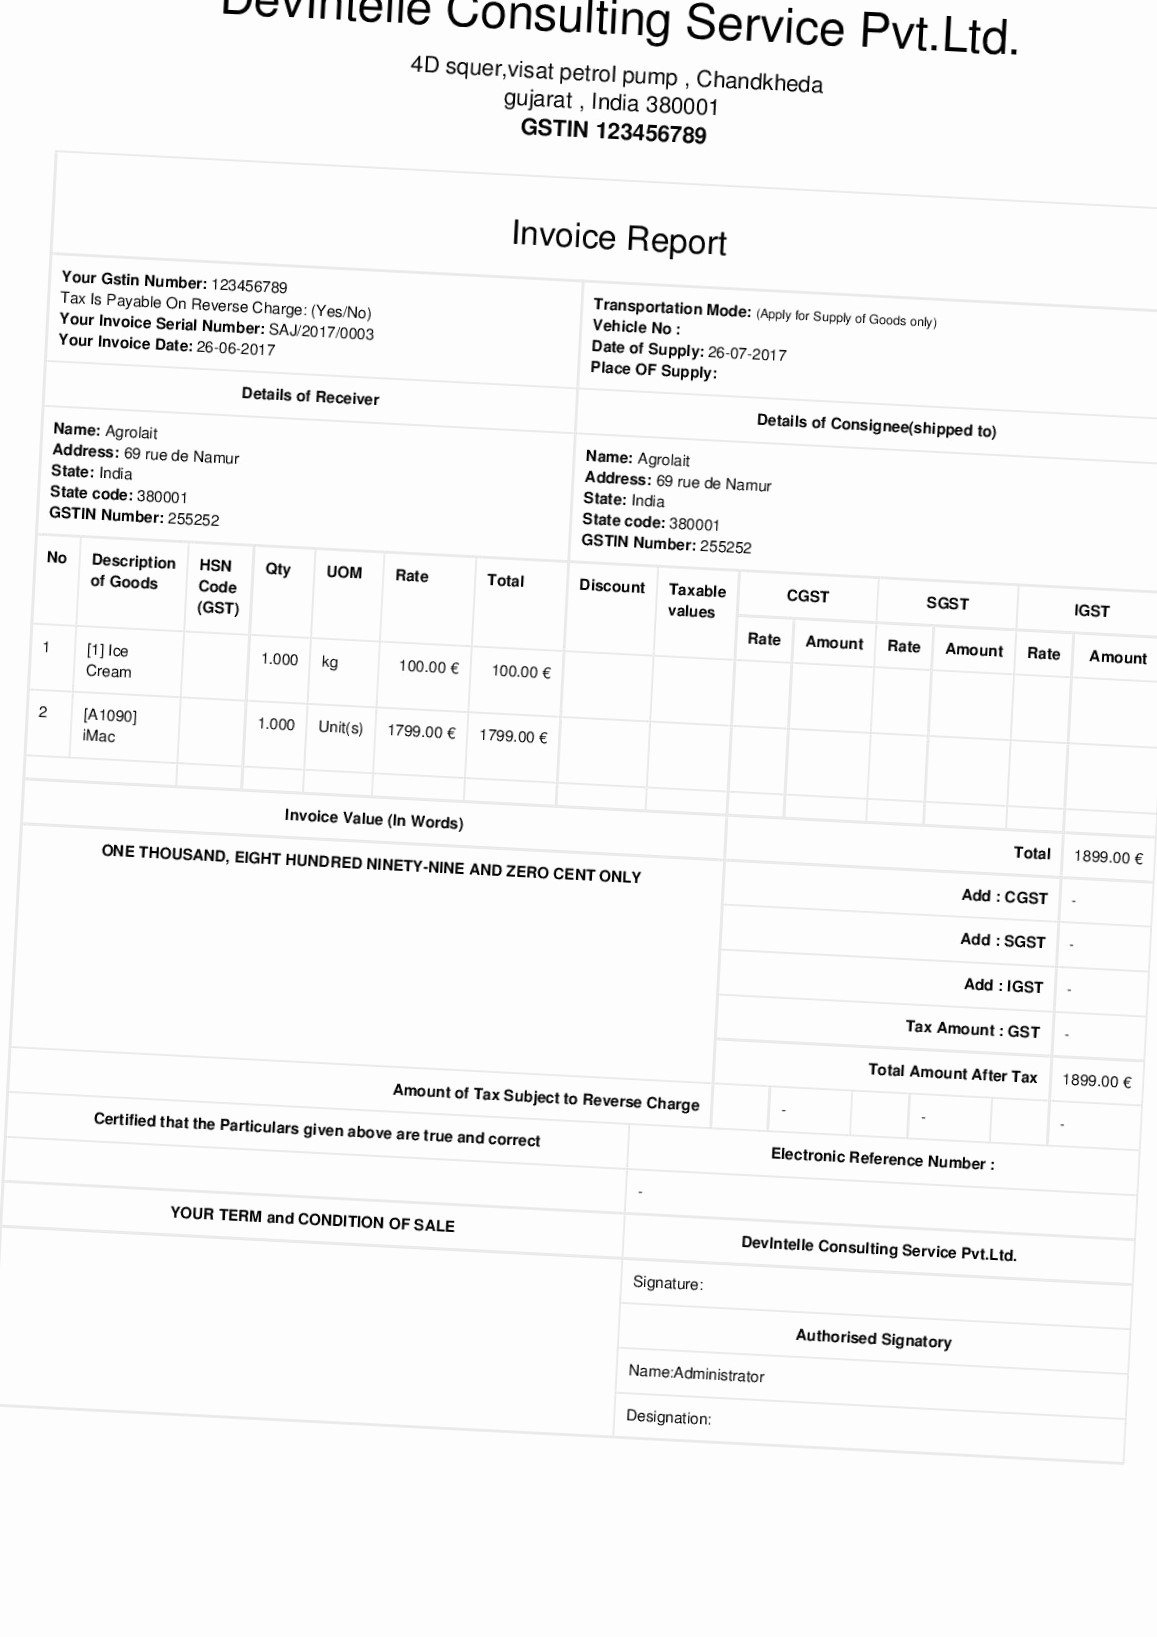

In [737]:
img

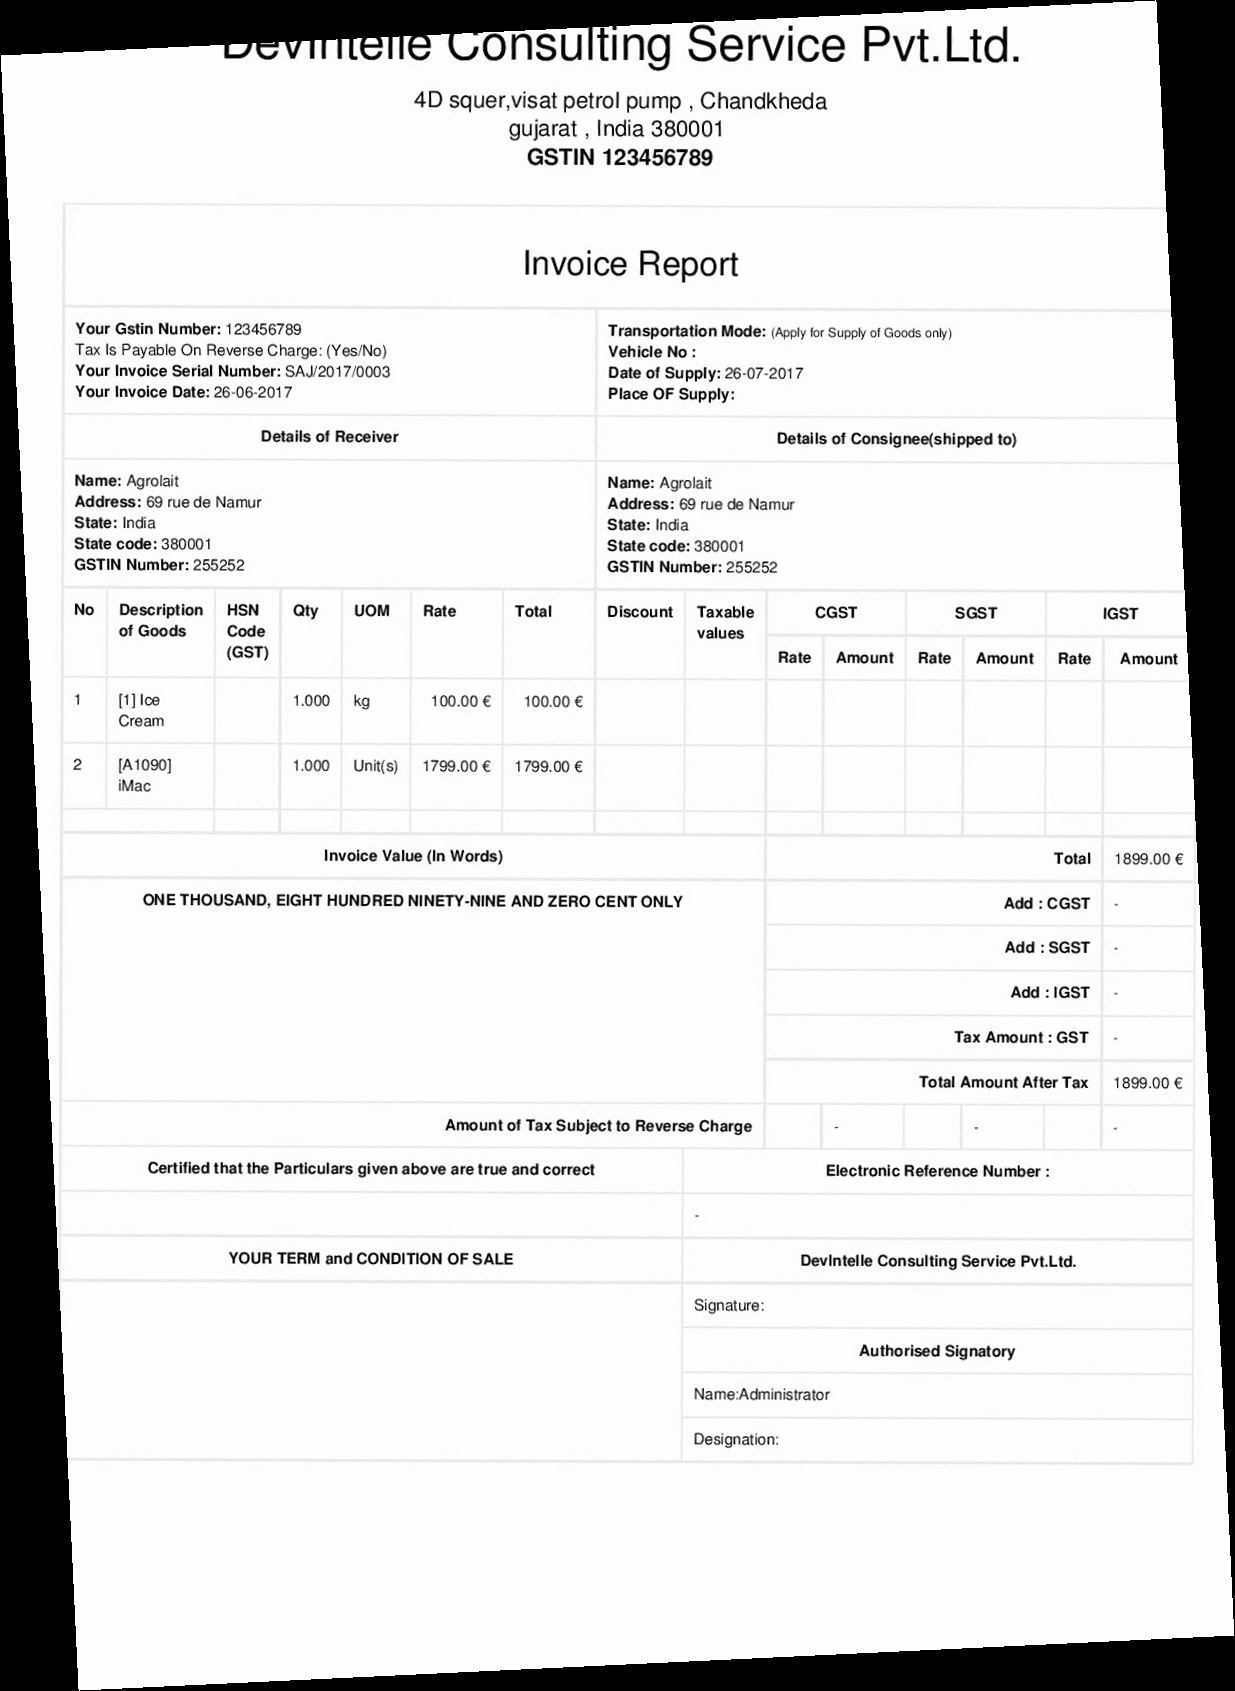

In [738]:
img.rotate(img_angle, resample=Image.BICUBIC, expand=True)#.rotate(90, expand=True)

In [739]:
img.size

(1157, 1637)

In [740]:
def concat_images(imgs):
    widths, heights = list(zip(*(img.size for img in imgs)))
    
    out_w = sum(widths)
    out_h = max(heights)
    
    out_img = PIL.Image.new("RGB", (out_w, out_h))
    x_spos = 0
    for img in imgs:
        out_img.paste(img, (x_spos, 0))
        x_spos += img.size[0]
    return out_img

In [822]:
'{angle:,.2f}'.format(angle=20.28936194628392)

'20.29'

In [852]:
1000//3

333

In [855]:
img.size

(7, 10)

In [856]:
img

In [880]:
def add_name_to_img(img, imgname, angle):
    
    w, h = img.size
    top_size = max(50, (h // 20))
    print(h, w, top_size)
    text = f'Image: "{imgname}" -- Angle: {angle:,.2f}°'

    out_img = Image.new("RGB", (w, h+top_size))
    out_img.paste(img, (0, top_size))
    
    d = ImageDraw.Draw(out_img)    
    font = PIL.ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", top_size-2)
    d.text((0, 0), text, font=font, fill='white')
    out_img = out_img.copy()
    out_img.thumbnail((700, 700))
    return out_img

1637 1157 81


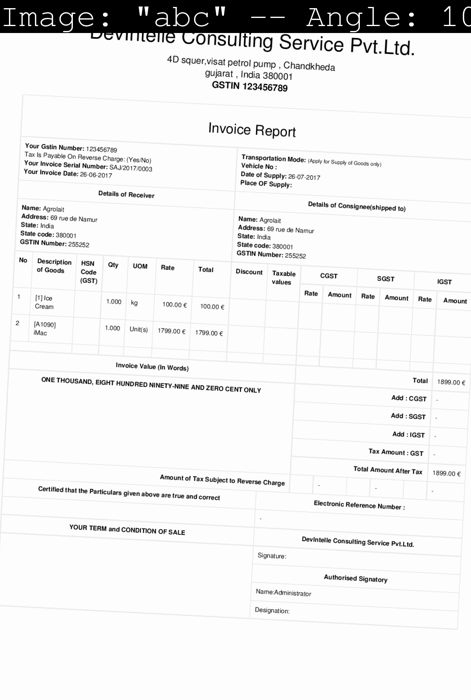

In [881]:
add_name_to_img(img, 'abc', 10)

In [884]:
from IPython.display import display
def main():
    for imgpath in root_path.rglob('*'):
        img = Image.open(imgpath)
        resp = make_apicall(img)
        med_angle = get_angle(img, resp, aggfn=statistics.median)
        mean_angle = get_angle(img, resp, aggfn=statistics.mean)
        
        med_img = img.rotate(med_angle, expand=True, resample=Image.BICUBIC)
#         mean_img = img.rotate(mean_angle, expand=True, resample=Image.BICUBIC)
        concat_img = concat_images([img, med_img])
#         concat_img = add_name_to_img(concat_img, imgpath.name, med_angle)
        
#         w, h = concat_img.size
#         concat_img.copy().thumbnail((1000, 200))
        print(imgpath.name, med_angle)
        display(concat_img)
        print('-'*80)

law-firm-invoice-template.jpg 90.85509739626673


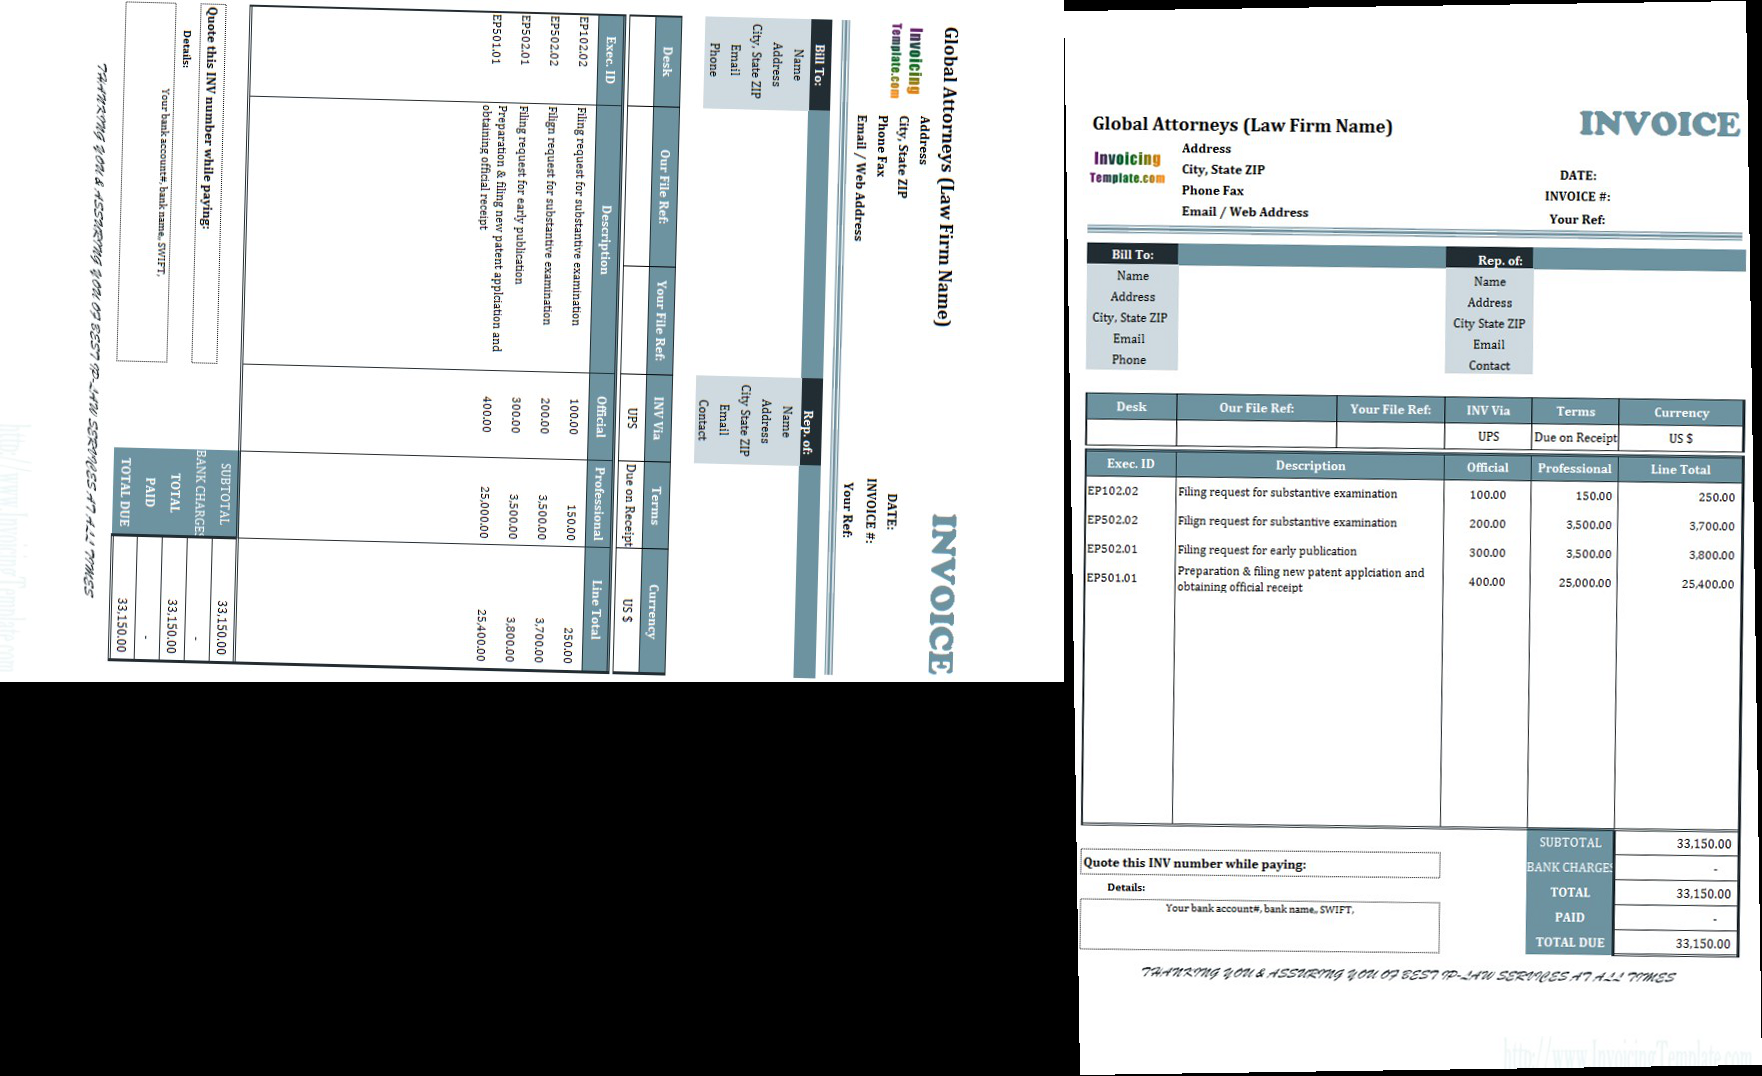

--------------------------------------------------------------------------------
0f97914844b786b0d2ef21339286cdf6 - 2.jpg -2.092109803701089


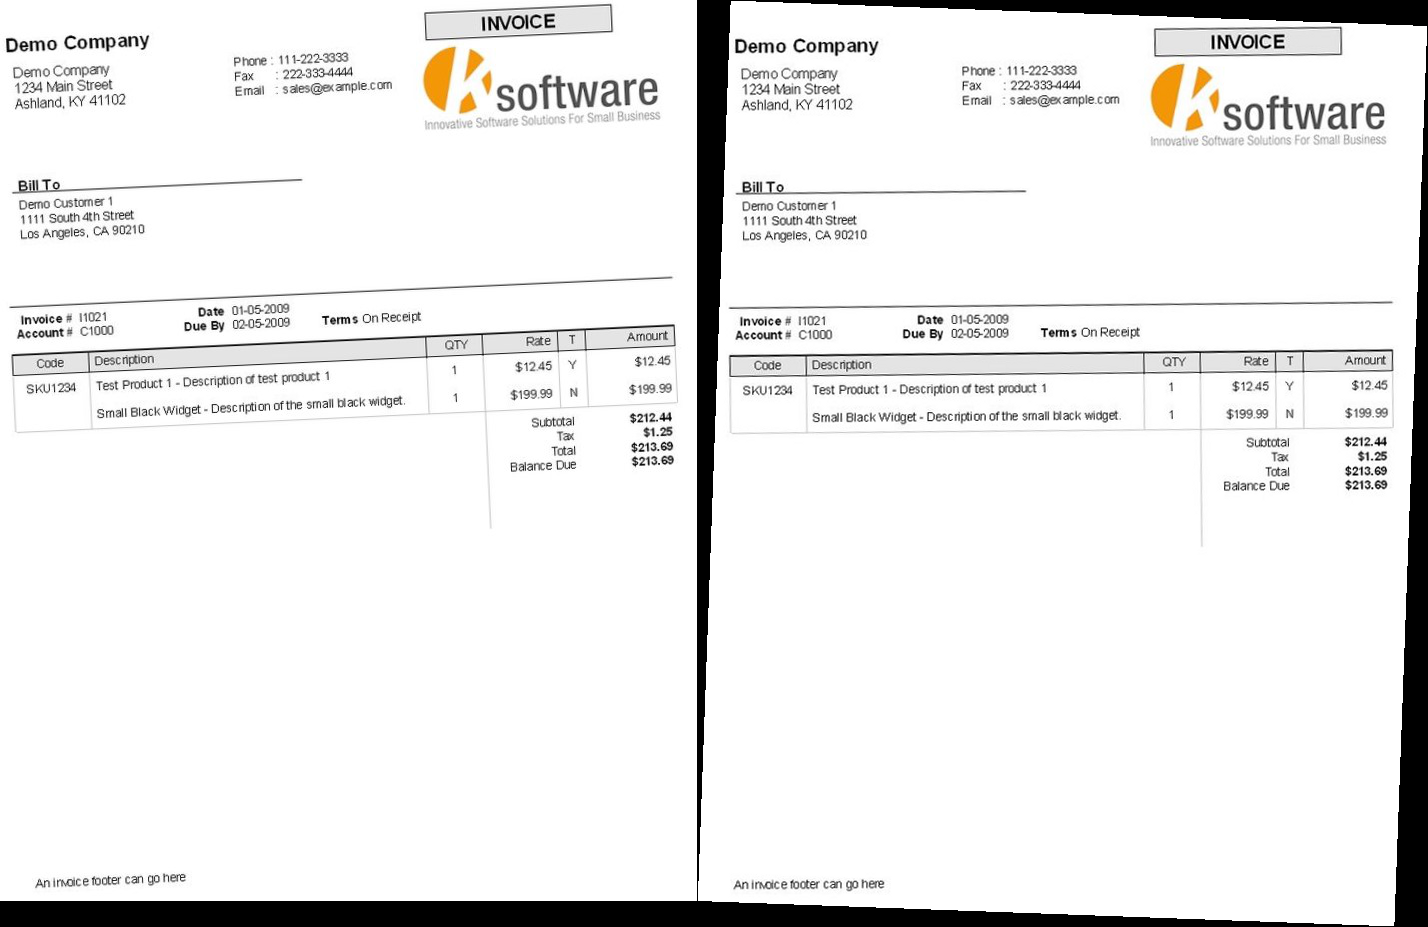

--------------------------------------------------------------------------------


KeyboardInterrupt: 

In [885]:
main()